In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
import statsmodels.api as sm

In [45]:
df = pd.read_csv(
    "C:/Users/Matias/OneDrive/Documentos/jupyter/CausalAI-Course/data/processed.cleveland.data",
    header=None
)

df.columns = [
    'age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg',
    'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd'
]

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [46]:
df = df.replace('?', np.nan)

df = df.astype(float)

df = df.dropna()

df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


In [47]:
np.random.seed(123)
df['T'] = np.random.choice([0, 1], size=len(df), p=[0.5, 0.5])
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,T
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0,0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0,1


In [48]:
epsilon = np.random.normal(0, 1, size=len(df))

df['Y'] = (
    (1 + 0.05*df['age'] + 0.3*df['sex'] + 0.2*df['restbp']) * df['T']
    + 0.5*df['oldpeak']
    + epsilon
)
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,T,Y
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0,1,34.369450
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0,0,0.795998
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0,0,1.225404
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0,1,30.787175
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0,1,29.425589


In [49]:
model_simple = sm.OLS(df['Y'], sm.add_constant(df['T']))  # include intercept
res_simple = model_simple.fit()
print("OLS simple: Y ~ T")
print(res_simple.summary().tables[1])
print("\nEfecto estimado (coef. de T) - OLS simple:", res_simple.params['T'])

OLS simple: Y ~ T
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4644      0.228      2.041      0.042       0.017       0.912
T             30.2482      0.320     94.486      0.000      29.618      30.878

Efecto estimado (coef. de T) - OLS simple: 30.248211368026777


In [50]:
covariates = ['age','sex','cp','restbp','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']
covariates = [c for c in covariates if c in df.columns]

In [51]:
X_adj = df[['T'] + covariates].copy()
X_adj = sm.add_constant(X_adj)
model_adj = sm.OLS(df['Y'], X_adj)
res_adj = model_adj.fit()
print("\nOLS ajustada: Y ~ T + covariables")
print(res_adj.summary().tables[1])
print("\nEfecto estimado (coef. de T) - OLS ajustada:", res_adj.params['T'])


OLS ajustada: Y ~ T + covariables
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.8017      1.887     -6.254      0.000     -15.516      -8.087
T             30.3027      0.240    126.302      0.000      29.830      30.775
age           -0.0057      0.016     -0.358      0.721      -0.037       0.026
sex            0.1358      0.291      0.467      0.641      -0.436       0.708
cp             0.1703      0.142      1.202      0.230      -0.109       0.449
restbp         0.0873      0.007     11.871      0.000       0.073       0.102
chol          -0.0009      0.002     -0.389      0.698      -0.006       0.004
fbs            0.5944      0.350      1.699      0.090      -0.094       1.283
restecg        0.0262      0.125      0.210      0.834      -0.219       0.272
thalach       -0.0022      0.007     -0.333      0.739      -0.015       0.011
exang         -0.

In [60]:
features = covariates

df_treated = df[df['T'] == 1].copy()
df_control = df[df['T'] == 0].copy()

rf_treated = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=-1)
rf_control = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=-1)

In [53]:
#Entrenar
rf_treated.fit(df_treated[features], df_treated['Y'])
rf_control.fit(df_control[features], df_control['Y'])

RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=123)

In [54]:
#Predecir
mu1_hat = rf_treated.predict(df[features])
mu0_hat = rf_control.predict(df[features])

In [55]:
cate_rf = mu1_hat - mu0_hat
df['cate_rf'] = cate_rf

In [56]:
ATE_rf = df['cate_rf'].mean()
print(f"\nATE estimado por T-learner (Random Forest): {ATE_rf:.6f}")


ATE estimado por T-learner (Random Forest): 30.256435


In [57]:
if all(v in df.columns for v in ['age','sex','restbp']):
    df['tau_true'] = 1 + 0.05*df['age'] + 0.3*df['sex'] + 0.2*df['restbp']
    ATE_true = df['tau_true'].mean()
    print(f"ATE verdadero (DGP): {ATE_true:.6f}")
    print(f"Diferencia ATE_RF - ATE_true: {ATE_rf - ATE_true:.6f}")
else:
    print("No se pudo calcular ATE verdadero (faltan variables).")

ATE verdadero (DGP): 30.268855
Diferencia ATE_RF - ATE_true: -0.012420


In [58]:
print("\nResumen de las CATEs estimadas por RF:")
print(pd.Series(df['cate_rf']).describe())


Resumen de las CATEs estimadas por RF:
count    297.000000
mean      30.256435
std        3.699556
min       23.391942
25%       27.126792
50%       30.093191
75%       32.565911
max       41.729116
Name: cate_rf, dtype: float64


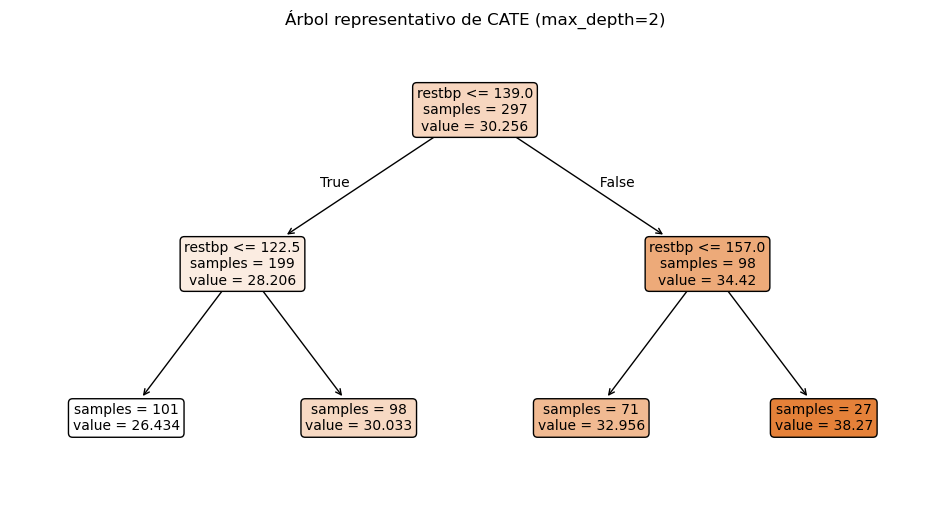

In [64]:
features.append('T')

tree_rep = DecisionTreeRegressor(max_depth=2, random_state=123)
tree_rep.fit(df[features], df['cate_rf'])

plt.figure(figsize=(12,6))
_ = plot_tree(tree_rep, feature_names=features, filled=True, rounded=True, fontsize=10, impurity=False)
plt.title("Árbol representativo de CATE (max_depth=2)")
plt.show()

In [65]:
print(features)

['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'T']


In [66]:
leaf_ids = tree_rep.apply(df[features])
leaf_summary = pd.DataFrame({'leaf': leaf_ids, 'cate_hat': df['cate_rf']})
leaf_stats = leaf_summary.groupby('leaf')['cate_hat'].agg(['count','mean','std']).sort_values('mean', ascending=False)
print("\nResumen por hoja del árbol representativo (count, mean, std):")
print(leaf_stats)


Resumen por hoja del árbol representativo (count, mean, std):
      count       mean       std
leaf                            
6        27  38.269591  1.426663
5        71  32.956148  1.036729
3        98  30.032526  0.827092
2       101  26.433744  1.116985


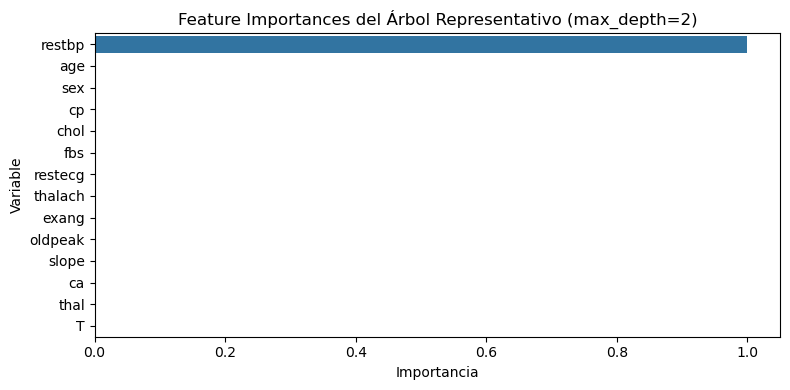

In [67]:
feature_imp = pd.DataFrame({
    'variable': features,
    'importance': tree_rep.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=feature_imp, x='importance', y='variable', color='C0').set(
    title='Feature Importances del Árbol Representativo (max_depth=2)',
    xlabel='Importancia',
    ylabel='Variable'
)
plt.tight_layout()
plt.show()

In [68]:
pd.DataFrame({
    'variable': features,
    'importance': tree_rep.feature_importances_
}).sort_values('importance', ascending=False)

,variable,importance
3,restbp,1.0
0,age,0.0
1,sex,0.0
2,cp,0.0
4,chol,0.0
5,fbs,0.0
6,restecg,0.0
7,thalach,0.0
8,exang,0.0
9,oldpeak,0.0


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)

C:\Users\Matias\AppData\Local\Temp\ipykernel_16976\3450701977.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_by_tercile = X_std.groupby(df['effect_tercile']).mean()


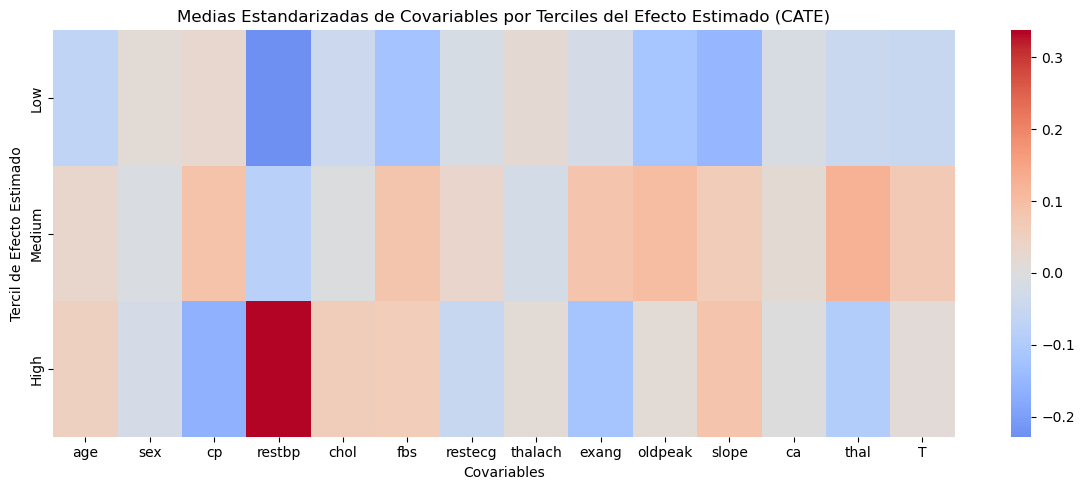

In [70]:
df['effect_tercile'] = pd.qcut(df['cate_rf'], q=3, labels=['Low', 'Medium', 'High'])


mean_by_tercile = X_std.groupby(df['effect_tercile']).mean()


plt.figure(figsize=(12,5))
sns.heatmap(mean_by_tercile, cmap='coolwarm', center=0)
plt.title('Medias Estandarizadas de Covariables por Terciles del Efecto Estimado (CATE)')
plt.xlabel('Covariables')
plt.ylabel('Tercil de Efecto Estimado')
plt.tight_layout()
plt.show()